# Pecipitation and the Mid-Latitude Seasonal Oscillation (MLSO) index
### Regression Analysis 
### Zak M

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from scipy.stats import linregress

#### Loading precip data

In [2]:
path = '/scratch/zmanthos/thesis/'
file = 'gpcp.lat25-55N.lon130-50W.nc'
files = path+file
data = xr.open_dataset(files,decode_times=True,decode_cf=True)

lat = data['latitude']
lon = data['longitude']

#### Loading the MLSO index

In [3]:
path1 = '/homes/zmanthos/thesis/index/'
file1 ='mlso.index.01011979-08312019.nc'
mlso = xr.open_dataset(path1+file1,decode_times=True,decode_cf=True)
mlso = mlso.sel(time=slice('1997-01-01','2018-12-31'))
print(len(mlso['time'].values))

8035


#### Making Timeseries Match

In [4]:
ndata = data.where(data['time'].isin(mlso['time'].values)).dropna(dim='time',thresh=1000)
test = ndata['time']==mlso['time']
print(test.where(test==True).count(dim='time').values)

8035


#### Computing Anomalies

In [5]:
clima = ndata.groupby('time.dayofyear').mean()
anoms = ndata.groupby('time.dayofyear') - clima;

#### Calculating Linear Regressions

In [6]:
llon=len(ndata['longitude'])
llat=len(ndata['latitude'])

pvalmap=np.zeros((llat,llon))
coremap=np.zeros((llat,llon))
slopemap=np.zeros((llat,llon))

for y in range(0,llon):
    for x in range(0,llat):
        xx = mlso['mlso']
        yy = anoms['precip'][:,x,y]
        xx=xx[np.logical_not(np.isnan(yy))]
        yy=yy[np.logical_not(np.isnan(yy))]
        m,b,r,p,e = linregress(xx,yy)
        coremap[x,y]=r
        pvalmap[x,y]=p
        slopemap[x,y]=m

print(coremap.shape)
print(pvalmap.shape)
print(slopemap.shape)



(31, 81)
(31, 81)
(31, 81)


#### Plotting Linear Regression Map

Setting font color

In [7]:
COLOR = 'white'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

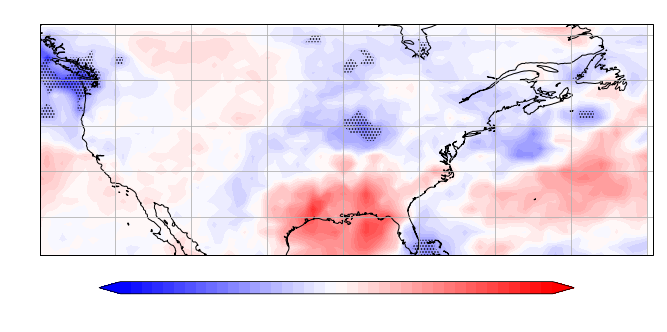

In [20]:
mask=np.where(pvalmap<0.05,slopemap,np.nan)
levels=np.linspace(-0.5,0.5,41)

fig = plt.figure(figsize=(11,8.5))
ax=plt.axes(projection=ccrs.PlateCarree())

cs=ax.contourf(anoms['longitude'],anoms['latitude'],slopemap,levels = levels, transform=ccrs.PlateCarree(),
            cmap='bwr',extend='both')
ax.contourf(anoms['longitude'],anoms['latitude'],mask,[0,1],
            transform = ccrs.PlateCarree(),colors='None',
            hatches=['....',''],extend='both',alpha=0)

ax.set_xticks(np.arange(-130,-49,10), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)

ys = ax.set_yticks(np.arange(25,56,10), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

ax.gridlines()
ax.coastlines(resolution='50m')

plt.title('Linear Regression Slope: Precipitation Anomalies & MLSO',fontsize='x-large',weight='bold')
cbar_ax = fig.add_axes([0.2, 0.25, 0.6, 0.02])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label='Slope')
fig.savefig('gpcp.mlso.regres.png')

#### A look at a single point 127W 48N

In [9]:
single = anoms['precip'].sel(latitude=48,longitude=(360-127))
#print(single)

In [10]:
xx = mlso['mlso']
yy = single[:]
xx=xx[np.logical_not(np.isnan(yy))]
yy=yy[np.logical_not(np.isnan(yy))]
m,b,r,p,e = linregress(xx,yy)
print('Slope: ',m)
print('Intercept: ',b)
print('Core Cof: ',r)
print('P-val: ',p)
print('Std Err: ',e)

Slope:  -0.37596571986802557
Intercept:  -0.018465201281742283
Core Cof:  -0.02849235118797108
P-val:  0.010817100147797912
Std Err:  0.1474867157741348


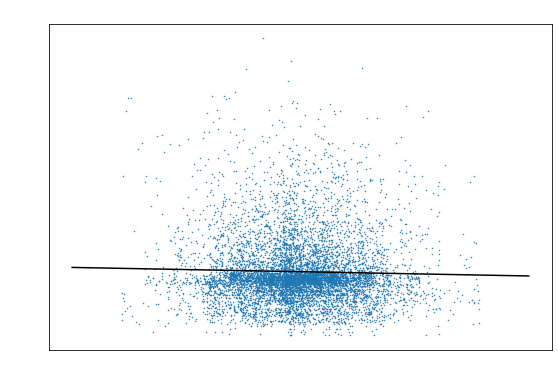

In [11]:
fig = plt.figure(figsize=(9,6))
plt.scatter(mlso['mlso'],single,s=0.25)
plt.plot(range(-4,5), b+m*range(-4,5), 'k')
plt.title('Linear Regression for 127W 48N',fontsize='x-large',weight='bold')
plt.xlabel('MLSO Index')
plt.ylabel('Precipitation Anomaly mm/day')
fig.savefig('single.regres.png')